**Exercise 1** \
Create 2D Gaussian distribution centred at origin \
Pick local maximum \
Walk from centre and see intensity distribution 


**Exercise 2** \
Create Mixture of gaussians \
Pick local maxima\
Walk from centre and see intensity distribution 

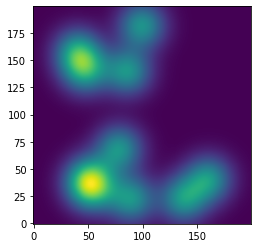

In [31]:
import numpy as np
from skimage.feature import peak_local_max
import scipy
from scipy import signal
from scipy import ndimage as ndi
from scipy.spatial import distance
import sys, copy, os
import matplotlib.pyplot as plt



"""
Create 2D gaussian kernel and place it at random location 
https://stackoverflow.com/questions/66580517/creating-a-gaussian-2d-array-with-mean-1-at-specificed-location
"""


N = 100 # kernel size
k1d = signal.gaussian(N, std=15) # returns row vector
k1d = k1d.reshape(N,1) # reshape k1d into column vector
kernel = np.outer(k1d,k1d) #generating Gaussian kernel (using outer product)
# plt.imshow(kernel)
# plt.gca().invert_yaxis()
# plt.show()

#generate image with gaussian at random location
size = 200 # image size

#xy coordinates of Gaussian in image
# x = [120,150,90,80,30]
# y = [90,120,150,40]

x = np.random.randint(size, size=10)
y = np.random.randint(size, size=10)

A = np.zeros((size,size))
A[y,x] = 1 #Generate peak at specified coordinates
# plt.imshow(A)
# plt.gca().invert_yaxis()
# plt.show()
img = signal.convolve2d(A,kernel, mode='same') #Generate image – convolve delta peak with Gaussian
plt.imshow(img)
plt.gca().invert_yaxis()
plt.show()


9  peaks identified...
Creating plot...


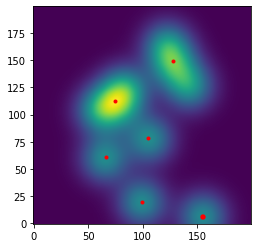

5 peak(s) too close to edge
Sampling from 4 peaks


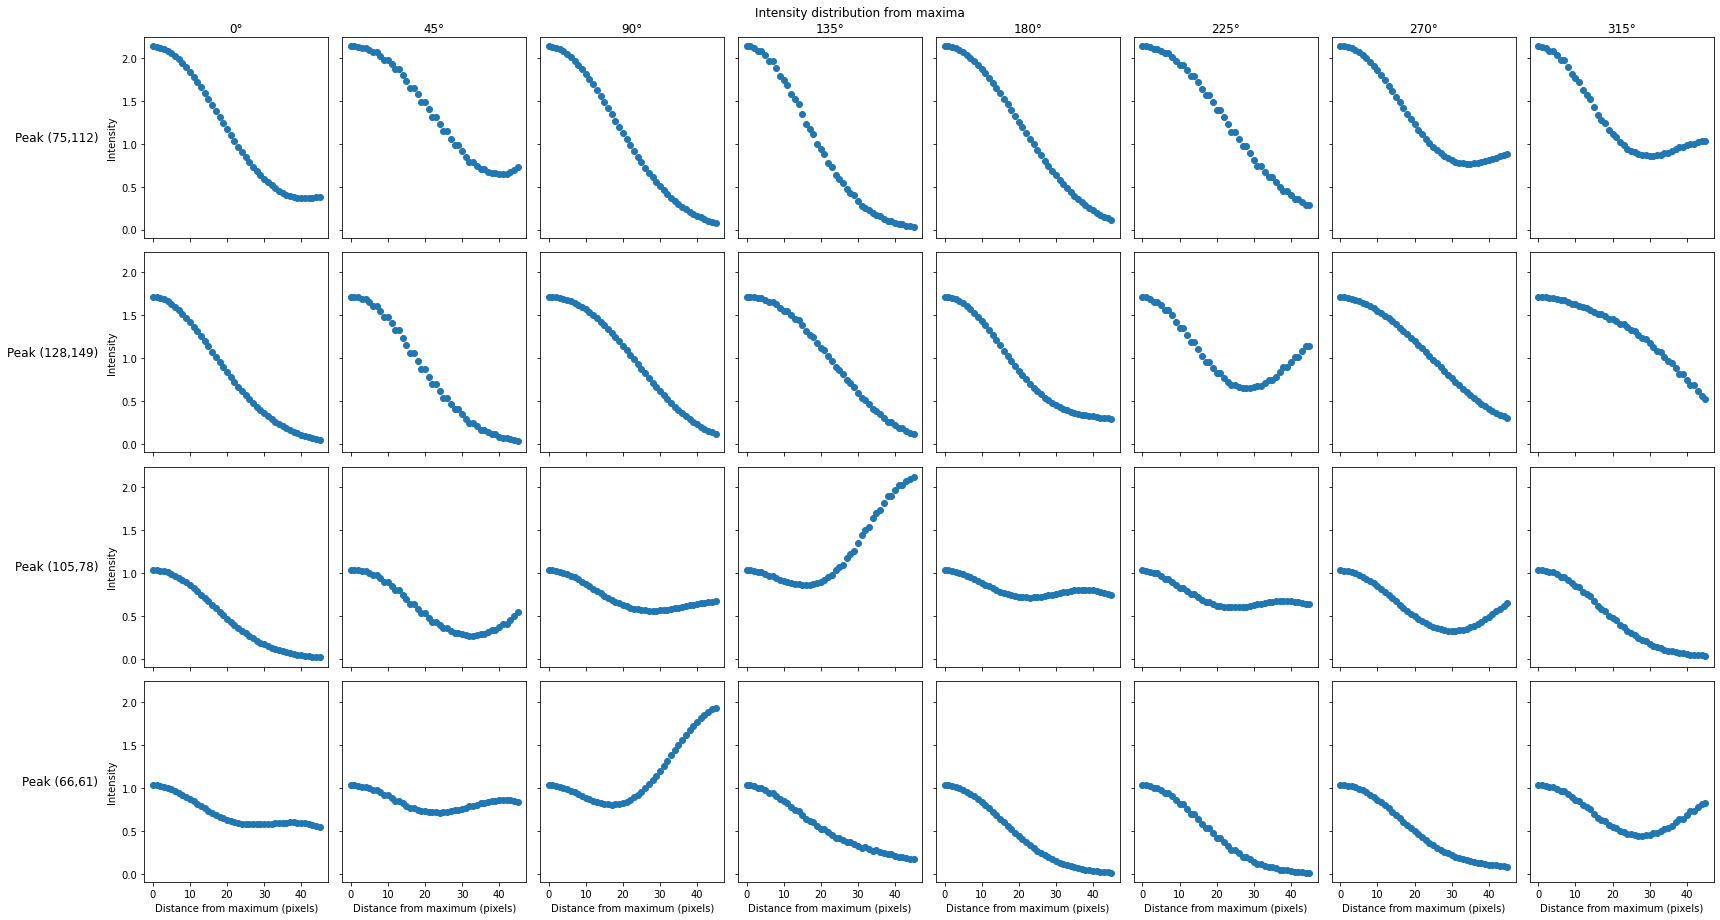

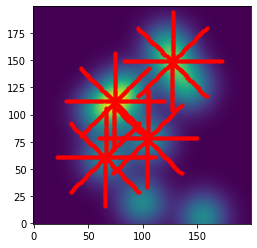

In [78]:
"""
find coordinates of local maximum

draw lines radiating from local maximum:
https://stackoverflow.com/questions/28417604/plotting-a-line-from-a-coordinate-with-and-angle
"""
# find peaks and coordinates
coords = peak_local_max(img, min_distance=1) #coords — N rows (N = number of peaks), 2 columns (x- and y-coordinates)
coords_rows, coords_cols = coords.shape #number of rows = number of peaks
y_peaks = coords[:,0] #row vector with y coordinates of peaks (N elements — N = number of peaks)
x_peaks = coords[:,1] #row vector with x coordinates of peaks (N elements — N = number of peaks)

N_peaks = len(x_peaks)
print(N_peaks, " peaks identified...")


print('Creating plot...')
plt.imshow(img)
plt.autoscale(False)
plt.plot(x_peaks,y_peaks, 'r.')
plt.gca().invert_yaxis()
plt.show()

"""
draw lines radiating from local maximum
"""
# define angle and length of line from local maximum
theta = np.arange(0,360,45) #angles sampled
r = 45 #length of line


# remove points too close to edge (defined using length of line sampled from local max)
array = np.ones((size,size), dtype=int)
array[:,[0,-1]] = array[[0,-1]] = 0
dfromedge = ndi.distance_transform_cdt(array, metric='chessboard')
disttoosmall = dfromedge[y_peaks,x_peaks] < r

x_peaks = np.delete(x_peaks, np.argwhere(disttoosmall==True))
y_peaks = np.delete(y_peaks, np.argwhere(disttoosmall==True))

N_angles = len(theta)
N_peaks = len(x_peaks)
N_peaks_disttoosmall = sum(disttoosmall)

print(N_peaks_disttoosmall, "peak(s) too close to edge")
print(f'Sampling from {N_peaks} peaks')

# find end points:
#   for each angle
#       for each peak
#           compute end point of line drawn out from peak

#initialising matrices for x and y coordinates for end poiNnts
#   rows(i) — N_rows = number of angles sampled
#   columns(j) – N_cols = number of peaks
#   value at i,j = x, y coordinates of particular end point at particular angle from peak
endy = np.zeros((N_angles,N_peaks))
endx = np.zeros((N_angles,N_peaks))

for i, angle in enumerate(theta):
    endy[i,:] = y_peaks + r*np.sin(np.radians(angle))
    endx[i,:] = x_peaks + r*np.cos(np.radians(angle))

endy = endy.astype(int) 
#row vector with y-coordinates of end points of line drawn from maximum – N_cols = N_peaks; N_rows = N_angles

endx = endx.astype(int) 
#row vector with x-coordinates of end points of line drawn from maximum — N_cols = N_peaks; N_rows = N_angles
# print(endx)
# print(endy)

#for each angle
#   for each peak
#       compute array of x and y coordinates, with interval 1 (to extract intensity values)
# i = len(theta) – number of angles sampled
# j = coords_rows – number of peaks
# k = r – number of points between peak and end point
# value at i,j,k = x,y coordinates of points on line drawn between maximum and end point

x = np.zeros((N_angles,N_peaks,r+1))
y = np.zeros((N_angles,N_peaks,r+1))

for i in range(N_angles):
    for j in range(N_peaks):
        y[i,j,:] = np.linspace(y_peaks[j], endy[i,j], r+1)
        x[i,j,:] = np.linspace(x_peaks[j], endx[i,j], r+1)

y=y.astype(int)
x=x.astype(int)

# print('x.shape=',x.shape)
# print('y.shape=',y.shape)


"""
calculate intensities and plotting:
"""
#   for each angle
#       for each peak
#           for each point in line between maximum and end point
#               find intensity
# i = len(theta) – number of angles sampled
# j = coords_rows – number of peaks
# k = r – number of points between peak and end point
# value at i,j,k = intensity values at particular x,y coordinates
I = img[y,x]

"""
plotting
"""
rows = N_peaks
cols = N_angles
fig, ax = plt.subplots(rows,cols,figsize=(3*N_angles,3*N_peaks+1),sharex=True,sharey=True)

fig.suptitle('Intensity distribution from maxima')
plt.setp(ax[-1,:],xlabel = 'Distance from maximum (pixels)')
plt.setp(ax[:,0],ylabel = 'Intensity')

for i in range(N_peaks): #for each peak
    for j in range(N_angles): #for each angle
        x_ax = np.arange(0,len(x[j,i,:]),1)
        ax[i,j].scatter(x_ax, I[j,i,:])

#labelling rows and columns of subplots (https://stackoverflow.com/questions/25812255/row-and-column-headers-in-matplotlibs-subplots)
col_labels = [f'{theta[i]}°' for i in range(N_angles)]
row_labels = [f'Peak ({x_peaks[i]},{y_peaks[i]})' for i in range(N_peaks)]

pad = 5 #in points

for axes, col in zip(ax[0], col_labels):
    axes.annotate(col, xy=(0.5, 1), xytext=(0, pad),
                xycoords='axes fraction', textcoords='offset points',
                size='large', ha='center', va='baseline')

for axes, row in zip(ax[:,0], row_labels):
    axes.annotate(row, xy=(0, 0.5), xytext=(-axes.yaxis.labelpad - pad, 0),
                xycoords=axes.yaxis.label, textcoords='offset points',
                size='large', ha='right', va='center')

fig.tight_layout()
plt.show()


xflat = x.ravel()
yflat = y.ravel()

plt.figure()
plt.imshow(img)
plt.autoscale(False)
plt.plot(xflat,yflat, 'r.')
plt.gca().invert_yaxis()
plt.show()




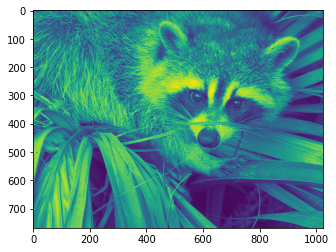

[[640.         639.2002816  638.40112782 ... 637.60254077 638.40112782
  639.2002816 ]
 [639.40050047 638.60003132 637.80012543 ... 637.00078493 637.80012543
  638.60003132]
 [638.80200375 638.0007837  637.20012555 ... 636.40003143 637.20012555
  638.0007837 ]
 ...
 [638.20451268 637.40254157 636.60113101 ... 635.80028311 636.60113101
  637.40254157]
 [638.80200375 638.0007837  637.20012555 ... 636.40003143 637.20012555
  638.0007837 ]
 [639.40050047 638.60003132 637.80012543 ... 637.00078493 637.80012543
  638.60003132]]


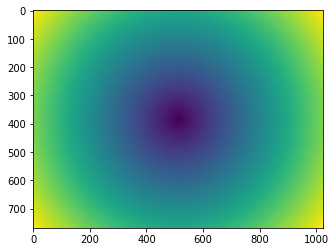

[[20 19 19 ... 19 19 19]
 [19 19 19 ... 19 19 19]
 [19 19 19 ... 19 19 19]
 ...
 [19 19 19 ... 19 19 19]
 [19 19 19 ... 19 19 19]
 [19 19 19 ... 19 19 19]]


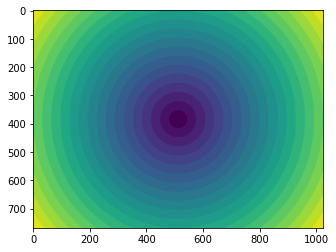

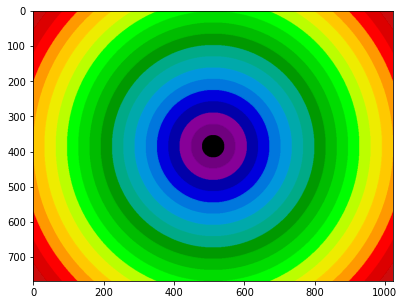

In [13]:
"""
Radial averaging
"""
f = scipy.misc.face(gray=True)
plt.figure()
plt.imshow(f)
plt.show()
sx, sy = f.shape
X, Y = np.ogrid[0:sx, 0:sy]
# print(X)
# print(Y)


r = np.hypot(X - sx/2, Y - sy/2)
print(r)
plt.figure()
plt.imshow(r)
plt.show()

rbin = (20* r/r.max()).astype(int)
print(rbin)
plt.figure()
plt.imshow(rbin)
plt.show()
radial_mean = ndi.mean(f, labels=rbin, index=np.arange(1, rbin.max() +1))

plt.figure(figsize=(5, 5))
plt.axes([0, 0, 1, 1])
plt.imshow(rbin, cmap=plt.cm.nipy_spectral)
# plt.axis('off')

plt.show()

In [ ]:
"""
Calculating spatial autocorrelations
"""

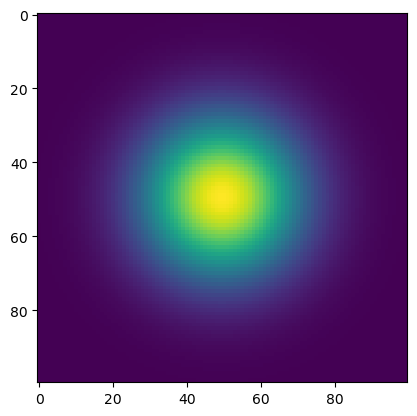

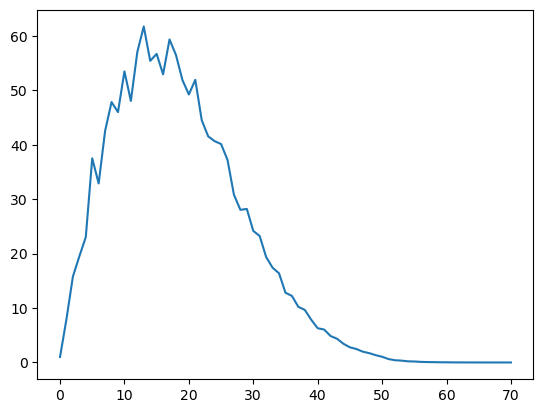

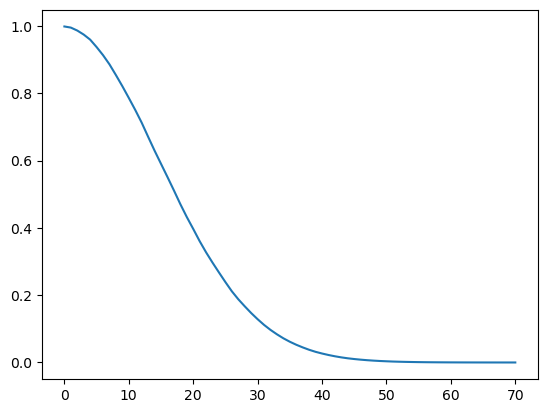

radialmean_scipy =  [9.95938583e-01 9.86774027e-01 9.66602823e-01 9.37682442e-01
 9.13592078e-01 8.69093727e-01 8.21313946e-01 7.69136635e-01
 7.12912285e-01 6.70965004e-01 6.09288328e-01 5.51414773e-01
 4.90827772e-01 4.32508115e-01 3.97072643e-01 3.44439689e-01
 2.96731851e-01 2.52479160e-01 2.11543388e-01 1.87894621e-01
 1.56262912e-01 1.28601068e-01 1.04404195e-01 8.37154192e-02
 7.18491416e-02 5.69164824e-02 4.48312170e-02 3.47307011e-02
 2.66609472e-02 2.22546342e-02 1.67220392e-02 1.24372653e-02
 9.26858893e-03 6.80971990e-03 5.49822926e-03 4.00602789e-03
 2.79834172e-03 2.00121277e-03 1.39787226e-03 1.09185214e-03
 7.57494699e-04 5.13346109e-04 3.45326183e-04 2.30538811e-04
 1.74986708e-04 1.19993572e-04 7.53278040e-05 4.69476658e-05
 3.00691246e-05 2.30660655e-05]


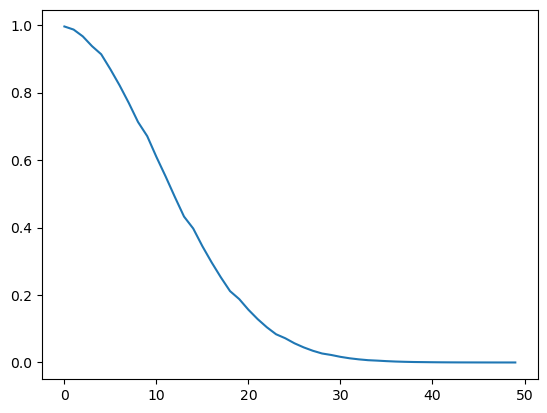

ValueError: x and y must have same first dimension, but have shapes (100, 100) and (50,)

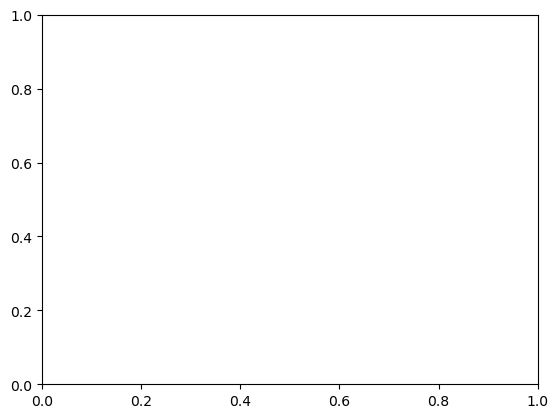

In [60]:
import numpy as np
from skimage.feature import peak_local_max
import scipy
from scipy import signal, stats
from scipy import ndimage as ndi
from scipy.spatial import distance
import sys, copy, os
import matplotlib.pyplot as plt

"""
https://stackoverflow.com/questions/21242011/most-efficient-way-to-calculate-radial-profile
https://stackoverflow.com/questions/48842320/what-is-the-best-way-to-calculate-radial-average-of-the-image-with-python
https://levelup.gitconnected.com/a-simple-method-to-calculate-circular-intensity-averages-in-images-4186a685af3

"""

N = 100 # kernel size
k1d = signal.gaussian(N, std=15) # returns row vector
k1d = k1d.reshape(N,1) # reshape k1d into column vector
kernel = np.outer(k1d,k1d) #generating Gaussian kernel (using outer product)
plt.imshow(kernel)
plt.show()

coords = peak_local_max(kernel, min_distance=10) #coords — N rows (N = number of peaks), 2 columns (x- and y-coordinates)
coords_rows, coords_cols = coords.shape #number of rows = number of peaks

#print(coords)
#print(coords[0,0],coords[0,1])

center = (coords[0,0],coords[0,1])
#print(center)

y, x = np.indices((kernel.shape)) #y = indices row-wise, x - indices column wise 
r = np.sqrt((x - center[0])**2 + (y - center[1])**2) #based on distance formula — computes Euclidean distance from centre for all points in array, creating distance field
r = r.astype(int)
mask = (r<50)



tbin = np.bincount(r.ravel(), kernel.ravel()) 
#r - distance from centre of peak (acts as Euclidean distance mask), 
#kernel - each element is the intensity value at each pixel
#np.bincount — sums intensity values as a function of distance from the peak
#tbin - a 1d array, each element in array corresponds to the 
#   summed intensities of groups of pixels that are equidistant from the centre of the peak

plt.figure()
plt.plot(tbin)

nr = np.bincount(r.ravel())
# nr — a 1d array, each element is a count of the number of pixels that are a defined distance from the centre of the peak

radialmean = tbin / nr
# radial profile - a 1d array, each element is the radially averaged intensity value 
#   (i.e. the intensity normalised to the count of pixels equidistant from peak centre)

plt.figure()
plt.plot(radialmean)
plt.show()

radialmean_scipy, mbinedges, mbinnumber = stats.binned_statistic(r.ravel(), kernel.ravel(),statistic='mean',bins=70)
radialstd_scipy, sbinedges, sbinnumber = stats.binned_statistic(r.ravel(), kernel.ravel(), statistic='std',bins=50)

binwidth = (mbinedges[1] - mbinedges[0])
bincentres = mbinedges[1:] - binwidth/2

print("radialmean_scipy = ", radialmean_scipy)

plt.figure()
plt.plot(radialmean_scipy)
plt.show()

plt.figure()
plt.plot(r, radialmean_scipy, 'r-', label='analytical pdf')
# plt.hlines(radialmean_scipy), mbinedges[:-1], mbinedges[1:], colors='g', lw=2,
#            label='binned statistic of data')
# plt.plot((mbinnumber - 0.5) * mbinwidth, x_pdf, 'g.', alpha=0.5)
# plt.legend(fontsize=10)
plt.show()

# plt.figure()
# plt.plot(radialmean_scipy)
# plt.show()

# plt.figure()
# plt.plot(radialstd_scipy)
# plt.show()


# TODO — still need to find a way to calculate radial standard deviation





